# NETWORKS

For the manuscript "Rate of temperature increase in marine ecosystems may influence species richness under climate change." This notebook defines the functions and runs the eco-evolutionary simulations. Code for supplemental figures S7 and S8 is also included. The functions should run without modification. The "Load packages" and "FUNCTIONS" sections are necessary for running simulations. The simulations for constant temperature should be run before running other experiments.

The variable "path" will need to be specified in order to run simulations and plot figures. Additional cells that can be modified by the user are preceded by markdown instructions.

The output files follow the naming conventions below: 
- For constant temperature: "N0_region_X_w[i]_V[j].npy", "SST_region_X_w[i]_V[j].npy", and "Z0_region_X_w[i]_V[j].npy"
- For changing temperature: "N1_region_X_w[i]_V[j].npy", "SST1_region_X_w[i]_V[j].npy", and "Z1_region_X_w[i]_V[j].npy"


Last update March 27, 2025

## Supplemental figures 
* [Figure S7. Comparison of ring and regular network](#Network)
* [Figure S8. Effects of additional mortality](#Mortality)

## Load packages

In [1]:
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set1')
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import time
import random
from netCDF4 import Dataset
import pandas as pd

%matplotlib inline

# FUNCTIONS

Essential functions for simulations

## Colormap function

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

## Growth rate function: growth_fun()

#### Function: 
Growth rate function (Equation (3) from supplemental material to Norberg et al. 2012). <br> 

#### Description: 
Calculate growth rate as a function of species trait (optimum temperature) and local environmental condition (reef temperature).

#### Parameters:
*r_max*:    Maximum growth rate for species <br> 
*T*:        Current temperature of reef <br> 
*z*:        Current optimum temperature for species <br> 
*w*:        Temperature tolerance <br> 
*species_type*: Species type ID that determines type of growth <br>

In [3]:
def growth_fun(r_max,T,z,w,species_type):
    if z.shape[0] > 1: # If there is more than one reef
        T = np.repeat(T,z.shape[1]).reshape(z.shape[0],z.shape[1])
    else: # If there is a single reef
        T = np.array([np.repeat(T,z.shape[1])])
        
    r = np.zeros((z.shape[0],z.shape[1])) #Preallocate growth vector
    coral_col = np.where(species_type == 1)[1]
    algae_col = np.where(species_type == 2)[1]
    r[:,coral_col] =( (r_max[:,coral_col]/np.sqrt(2.*np.pi*pow(w[:,coral_col],2.)))
                    *np.exp((-pow((T[:,coral_col]-z[:,coral_col]),2.))/(2*pow(w[:,coral_col],2.))) )
    r[:,algae_col] = 0.49 * r_max[:,algae_col]

    return r

## Mortality function: mortality_fun()

Mortality rate function proposed as an alternative to constant mortality rate from Norberg et al. (2012) <br>
Determines mortality rate as a function of species trait (optimum temperature) and local environmental condition (reef
temperature).

Note: MPA status only affects algal mortality rate

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*:  Protected area status of the reef <br>
*alg_mort*: algal mortality rate in non-mpa reefs

In [4]:
# Original mortality function
def mortality_fun(r_max,T,z,w,species_type,mpa_status,alg_mort):
    
    m = np.zeros((z.shape[0],z.shape[1])) # Preallocate mortality vector
    algae_col = np.array([np.where(species_type == 2)[1]]) # Find algae columns
    
    if z.shape[0] > 1: # If there is more than one reef
        T = np.repeat(T,z.shape[1]).reshape(z.shape[0],z.shape[1]) # Reshape T array to correspond with z matrix
        
        m[z<T] = 1 - np.exp(-pow((T-z),2)/pow(w,2))[z<T]
#         m[z<T] = 0 #testing mortality function HERE
        m[z>=T] = 0
        
        # Indices of mpa reefs (corresponds to rows in N_all)
        is_mpa = np.array([np.where(mpa_status == 1)[1]]) 
        # Indices of non-mpa reefs (corresponds to rows in N_all)
        not_mpa = np.array([np.where(mpa_status != 1)[1]])
        
        # Create arrays of indices that correspond to is_mpa & algae_col and not_mpa & algae_col
        is_mpa_rows = np.array([is_mpa.repeat(algae_col.shape[1])]) 
        not_mpa_rows = np.array([not_mpa.repeat(algae_col.shape[1])])
        algae_col_is_mpa = np.tile(algae_col,is_mpa.shape[1])
        algae_col_not_mpa = np.tile(algae_col,not_mpa.shape[1])

        # Macroalgae calculations for multiple reefs
        m[is_mpa_rows,algae_col_is_mpa] = 0.3
        m[not_mpa_rows,algae_col_not_mpa] = alg_mort[not_mpa_rows]
        
    else: # If there is a single reef
        T = np.array([np.repeat(T,z.shape[1])])
    
        #Coral calculations
        m[z<T] = 1 - np.exp(-pow((T-z),2)/pow(w,2))[z<T]
        m[z>=T] = 0
        
        # Macroalgae calculations for a single reef
        if mpa_status == 1:
             m[0,algae_col] = 0.3
        else:
            m[0,algae_col] = alg_mort

    # Apply a correction such that the minimum amount of mortality experienced is 0.03        
    m[m<0.03] = 0.03
    
    return m

## Fitness function: fitness_fun

Fitness function (Equation (2) from supplemental material to Norberg et al. 2012). Determines fitness as a 
function of local growth rate, mortality rate, and species interactions (competition for space).

#### Calls:
growth_fun( )<br>
mortality_fun( )

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: algal mortality rate in non-mpa reefs

#### Returns:
*g*: A matrix containing the fitness of all species at all reefs, or a single vector of species fitness if there is only one reef

#### Notes: 
The functions growth_fun( ) and mortality_fun( ) already adjust the temperature vector so there is no need to do that in this function. 

In [5]:
def fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort):
    r = growth_fun(r_max,T,z,w,species_type)
    
    # If mortality varies with temperature
    if mortality_model == "temp_vary":
        m = mortality_fun(r_max,T,z,w,species_type,mpa_status,alg_mort)    
    # If mortality is constant
    else: 
        m = m_const
    
    #If there is more than one reef
    if N_all.shape[0] > 1:
        sum_interactions = np.array([np.sum(N_all[index,:] * alphas, axis=1) for index in range(N_all.shape[0])])
    else:
        sum_interactions = np.sum(alphas * N_all, axis=1)

    g = r * (1-sum_interactions) - m
    
    return g

## Function to calculate dg/dz: dGdZ_fun()

Function to calculate the partial derivative of growth rate across changes in trait space. This function is used in the directional selection component of equation (1b) in the Norberg et al. 2012 supplemental material. 

#### Calls:
fitness_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Vector of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: algal mortality rate in non-mpa reefs

In [6]:
def dGdZ_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort):
    h = 1e-5
    dGdZ = np.zeros(z.shape)
    
    #If there is more than one reef
    if N_all.shape[0] > 1:
        # For each reef
        for i in np.arange(z.shape[0]): 
            # For each species
            for j in np.arange(z.shape[1]):
                h_matrix = np.zeros(z.shape)
                h_matrix[i,j] = h
                # Take the symmetric difference quotient at point z[i,j]
                term1 = fitness_fun(r_max,T,z+h_matrix,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
                term2 = fitness_fun(r_max,T,z-h_matrix,w,alphas,species_type,mpa_status,
                                         N_all,m_const,mortality_model,alg_mort)
                delta = (term1-term2)/(2*h)
                dGdZ[i,j] = delta[i,j]
    else:
        for j in np.arange(z.shape[1]):
            h_array = np.zeros(z.shape)
            h_array[0,j] = h
            # Take the symmetric difference quotient at point z[i,j]
            term1 = fitness_fun(r_max,T,z+h_array,w,alphas,species_type,mpa_status,
                                 N_all,m_const,mortality_model,alg_mort)
            term2 = fitness_fun(r_max,T,z-h_array,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
            delta = (term1-term2)/(2*h)
            dGdZ[0,j] = delta[0,j]
            
    return dGdZ

## Function to calculate d2g/dz2: dGdZ2_fun()

Function to calculate the second partial derivative of growth rate across changes in trait space. This function is used in the genetic laod component of equation (1a) in the Norberg et al. 2012 supplemental material. 

Calls: fitness_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: algal mortality rate in non-mpa reefs


In [7]:
def dGdZ2_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort):
    h = 1e-5
    dGdZ2 = np.zeros(z.shape)
    
    #If there is more than one reef
    if N_all.shape[0] > 1:
        # For each reef
        for i in np.arange(z.shape[0]): 
            # For each species
            for j in np.arange(z.shape[1]):
                h_matrix = np.zeros(z.shape)
                h_matrix[i,j] = h
                # Take the symmetric difference quotient at point z[i,j]
                term1 = fitness_fun(r_max,T,z+h_matrix,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
                term2 = fitness_fun(r_max,T,z-h_matrix,w,alphas,species_type,mpa_status,
                                         N_all,m_const,mortality_model,alg_mort)
                term3 = fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,
                                         N_all,m_const,mortality_model,alg_mort)
                delta = (term1+term2-2*term3)/pow(h,2)
                dGdZ2[i,j] = delta[i,j]
                
    else:
        for j in np.arange(z.shape[1]):
            h_array = np.zeros(z.shape)
            h_array[0,j] = h
            # Take the symmetric difference quotient at point z[i,j]
            term1 = fitness_fun(r_max,T,z+h_array,w,alphas,species_type,mpa_status,
                                 N_all,m_const,mortality_model,alg_mort)
            term2 = fitness_fun(r_max,T,z-h_array,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
            term3 = fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,
                                     N_all,m_const,mortality_model,alg_mort)
            delta = (term1+term2-2*term3)/pow(h,2)
            dGdZ2[0,j] = delta[0,j]
            
    return dGdZ2

## Function to calculate dN/dt: dNdt_fun()

Function to calculate the derivative of percent cover across time. Based on equation (1a) in the Norberg et al. 2012 supplemental material. 

#### Calls: 
fitness_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: Algal mortality rate in non-mpa reefs <br>
*V*: Genetic variation <br>
*D*: Dispersal matrix (same for all species) <br>
*beta*: Vector of combined dipsersal and effective fecundity rate

In [8]:
def dNdt_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort,V,D,beta):    
    
    if N_all.shape[0] > 1:
        V = np.tile(V, N_all.shape[0]).reshape(N_all.shape[0],N_all.shape[1])
    
    g = fitness_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort)
    dGdZ2 = dGdZ2_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort)      
    popdy = np.multiply(N_all,g)
    genload = 0.5 * V * dGdZ2 * N_all
    
    dispersal = beta * np.dot(D,N_all)
    free_space = 1 - N_all.sum(axis=1)
    larval_input = np.array([dispersal[index,:] * x for index, x in enumerate(free_space)])
    
    algae_ID = np.where(species_type==2)[1] #find algae columns
    larval_input[:,algae_ID] = 0
    
    dNdt = popdy + genload + larval_input
    
    #! Prevent NaN or population values below 1e-6 in output
    if np.isnan(dNdt).any():
        ID = np.where(np.isnan(dNdt))
        dNdt[ID] = 1e-6
    if (dNdt+N_all < 1e-6).any():
        ID = np.where(dNdt+N_all < 1e-6)
        dNdt[ID] = 1e-6

    return dNdt

## Function to calculate q: q_fun()

Function to prevent directional selection of virtually extinct populations and enhance numerical stability. Described in supplemental material of Norberg et al (2012).

#### Parameters:
*N_all*: Matrix of abundance for all species <br>
*N_min*: Minimum value for percent cover at any given location

In [9]:
def q_fun(N_all, N_min=1):
    q = np.maximum(0, 1- N_min/(np.maximum(N_min,2*N_all)))
    return q

## Function to calculate dZ/dt: dZdt_fun()

Function to calculate the derivative of average trait value across time. Based on equation (1b) in the Norberg et al. 2012 supplemental material. 

#### Calls: 
fitness_fun() <br>
dGdZ_fun()

#### Parameters:

*r_max*: Maximum growth rate (potentially used for other mortality functional forms) <br>
*T*:   Current temperature of reef <br>
*z*:   Current optimum temperature for species <br>
*w*:   Temperature tolerance <br>
*alphas*: Species interaction matrix <br>
*species_type*: Species type ID that determines type of mortality <br>
*mpa_status*: Protected area status of the reef <br>
*N_all*: Matrix of abundance for all species <br>
*m_const*: Constant mortality rate <br>
*mortality_model*: Use either constant or temperature-varying mortality be used? ("temp_vary" or "constant") <br>
*alg_mort*: Algal mortality rate in non-mpa reefs <br>
*V*: Genetic variation <br>
*D*: Dispersal matrix (same for all species) <br>
*beta*: Vector of combined dipsersal and effective fecundity rate <br>

In [10]:
def dZdt_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort,V,D,beta):
        
    if N_all.shape[0] > 1:
        V = np.tile(V, N_all.shape[0]).reshape(N_all.shape[0],N_all.shape[1])
    
    q = q_fun(N_all)
    dGdZ = dGdZ_fun(r_max,T,z,w,alphas,species_type,mpa_status,N_all,m_const,mortality_model,alg_mort)
    directional_selection = q * V * dGdZ
    gene_flow_term1 = (np.dot(D, N_all * z) / np.dot(D, N_all)) - z
    gene_flow_term2 = (beta * np.dot(D, N_all)) / (N_all)
    free_space = 1 - N_all.sum(axis=1)
    gene_flow = np.array([(gene_flow_term1*gene_flow_term2)[index,:] * x for index, x in enumerate(free_space)])
    
    algae_ID = np.where(species_type==2)[1] #find algae columns
    gene_flow[:,algae_ID] = 0
    
    dZdt = directional_selection + gene_flow
    
    return dZdt

## Function to generate initial temperatures across the reef: generate_temps()

Function to generate temperatures across the reef. Temperatures can take on several patterns, including uniform, linear increase, or randomized

#### Parameters:

*size*: Number of patches in the network <br>
*mid*: Mean of the temperature range on reef <br>
*range*: Range of temperatures across reef <br>
*temp_scenario*: Temperature scenario. **Uniform** has same (mid value) temperature at all locations. 
**Linear** has a linearly increasing temperature centered on mid value. 
**Random** draws a random temperature for each patch from a normal distribution with mean equal to mid value, and sd equal to half of range value.

In [11]:
def generate_temps_fun(size,mid=25,temp_range=2.5,temp_scenario='linear'):
    if temp_scenario == 'uniform':
        temps = np.repeat(mid,size)
    if temp_scenario == 'linear':
        temps = np.linspace(mid-temp_range, mid+temp_range, size)
    elif temp_scenario == 'random':
        a = np.linspace(mid-temp_range, mid+temp_range, size)
        temps = np.random.choice(a, size, replace=False, p=None)
    return temps

In [12]:
# UPDATED LINEAR TEMP FUNCTION 
def generate_temps_linear(size,min_SST,max_SST):
    temps = np.linspace(min_SST, max_SST, size)
    return temps

In [13]:
def generate_temps_cos_fun(size,min_SST=20,max_SST=30):
    range_SST = max_SST - min_SST
    mid = range_SST/2
    mid_SST = (max_SST + min_SST)/2
    x_vals = np.linspace(0,2,size)
    cos_vals = mid * np.cos(np.pi*x_vals) + mid_SST
    return cos_vals

In [14]:
generate_temps_fun(20)

array([22.5       , 22.76315789, 23.02631579, 23.28947368, 23.55263158,
       23.81578947, 24.07894737, 24.34210526, 24.60526316, 24.86842105,
       25.13157895, 25.39473684, 25.65789474, 25.92105263, 26.18421053,
       26.44736842, 26.71052632, 26.97368421, 27.23684211, 27.5       ])

## Function to generate initial traits across the reef: generate_traits_fun()

Function to generate traits across the reef. Traits can take on several patterns including uniform, linear increase or randomized. Traits represent the optimum temperature for species i at each location.

#### Parameters:
*nsp*: Number of species in the model <br>
*size*: Number of patches in the network <br>
*mid*: Mean of the temperature range on reef <br>
*range*: Range of temperatures across reef <br>
*temps*: Temperatures at each reef location <br>
*trait_scenario*: Trait scenario. **u_constant** has unique traits for each species, which are constant across the network. **perfect_adapt** has perfectly adapted organisms, whose traits are equal to the temperature on the reef patch. **same_constant** produces the same trait for all species at all patches.

In [15]:
def generate_traits_fun(nsp,size,temps,mid=25,temp_range=2.5,trait_scenario='perfect_adapt'):
    if trait_scenario == 'u_constant':
        a = np.linspace(mid-(temp_range/4), mid+(temp_range/4), nsp+2)[1:-nsp+2]
        b = np.repeat(a,size)
        traits = np.reshape(b,(nsp,size))
    if trait_scenario == 'same_constant':
        traits = np.full((nsp,size),mid)
    elif trait_scenario == 'perfect_adapt':
        a = np.tile(temps,nsp)
        traits = np.reshape(a,(nsp,size))
    return traits.T

## Function to generate starting percent covers for all species at each patch: generate_state_fun()

In [16]:
def generate_state_fun(size, nsp, cover=0.01,random=False):
    state = np.full((size,nsp),cover)
    if random:
        state = np.full(nsp*size,np.random.uniform(1e-6,.33,nsp*size)).reshape(size,nsp)
    return state

## Function to set MPA design relative to protection strategy: set_MPA_fun()


In [17]:
def set_MPA_fun(temps,N_all,species_type,size,amount=0.2,strategy='random'):
    mpa = np.zeros(size)
    ID = np.where(species_type==1)[1]
    corals = N_all[:,ID].sum(axis=1) # Get the subset of N_all that corresponds to coral cover per reef
    #The following line applies to the 'portfolio' strategy that I haven't coded here
    ncoral = np.asarray(np.where(species_type==1)).sum() # How many coral species?
    
    if strategy == 'none':
        index = np.asarray([])
    elif strategy=='hot':
        index = (-temps).argsort()[0:np.int(amount*size)]
    elif strategy=='cold':
        index = temps.argsort()[0:np.int(amount*size)]
    elif strategy=='hotcold':
        index = np.r_[0:np.int(amount*size/2),np.int(size-(amount*size/2)):np.int(size)]
    elif strategy=='space':
        index = np.round(np.linspace(0,size-1,np.int(amount*size)))
    elif strategy=='highcoral':
        index = (-corals).argsort()[0:np.int(amount*size)]
    elif strategy=='lowcoral':
        index = corals.argsort()[0:np.int(amount*size)]
    elif strategy=='random':
        index = np.random.choice(np.arange(0,size),np.int(amount*size), replace=False)
    
    mpa[index.astype(int)]=1
    return np.array([mpa])   

## Function to calculate partial derivatives of pop growth, trait change and temperature change: coral_trait_stoch_fun()

In [18]:
def coral_trait_stoch_fun0(param,spp_state,trait_state,temps,anomalies,algaemort_full,temp_change="constant"):
   
    nsp = param['nsp']
    size = param['size']
    time_steps = param['time_steps']
    species_type = param['species_type']
    r_max = param['r_max']
    V = param['V']
    D = param['D']
    beta = param['beta']
    m_const = param['m_const']
    w = param['w']
    alphas = param['alphas']
    mpa_status = param['mpa_status']
    mortality_model = param['mortality_model']
    maxtemp = param['maxtemp']
    annual_temp_change = param['annual_temp_change']
    timemod = param['timemod']

    SST_matrix = np.zeros([size,time_steps])
    SST_matrix[:,0] = temps    
    
    for i in np.arange(1, time_steps):
        if temp_change == "sigmoid":
            temps =  SST_matrix[:,i-1] + anomalies[:,i-1]
            dtemp1 = annual_temp_change*temps.mean()
            dtemp2 = 1-(temps.mean()/maxtemp)
            dtemp = np.repeat(dtemp1*dtemp2, size)
            
        if temp_change == "constant":
            dtemp = np.repeat(0, size)
            
        if temp_change == "linear":
            dtemp = np.repeat(annual_temp_change, size)
            
        SST_matrix[:,i] = SST_matrix[:,i-1] + dtemp
    
    N_ALL = np.zeros((size,nsp,time_steps))
    Z_ALL = np.zeros((size,nsp,time_steps))
    N_ALL[:,:,0] = spp_state
    Z_ALL[:,:,0] = trait_state

    algaemort_sub = algaemort_full[:,timemod:timemod+time_steps]
    tick = 0
    
    # Second-order Runge Kutta solver
    for i in np.arange(0,time_steps-1):
        alg_mort = algaemort_sub[:,i]
        dN1 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                         N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)
        dZ1 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL[:,:,tick],w,alphas,species_type,mpa_status,
                        N_ALL[:,:,tick],m_const,mortality_model,alg_mort,V,D,beta)

        N_ALL_1 = N_ALL[:,:,tick] + dN1*.5
        Z_ALL_1 = Z_ALL[:,:,tick]  + dZ1*.5

        dN2 = dNdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                         N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)
        dZ2 = dZdt_fun(r_max,SST_matrix[:,tick],Z_ALL_1,w,alphas,species_type,mpa_status,
                        N_ALL_1,m_const,mortality_model,alg_mort,V,D,beta)

        N_ALL[:,:,tick+1] = N_ALL[:,:,tick] + (dN1 + dN2)/2
        Z_ALL[:,:,tick+1] = Z_ALL[:,:,tick] + (dZ1 + dZ2)/2

        tick += 1
    
    return N_ALL, Z_ALL, SST_matrix

# Parameters

Set the default parameter values for eco-evo simulations

In [19]:
nsp = 1 # Number of species in model
size = 20 # Number of reefs in model, size is 60 in Walsworth et al. model
burnin = 1500 # Length of burn-in period
runtime = 500 # Length of environmental change period
mid = 27. # Mean temperature across all reefs at start of simulation
temp_range = 10. # Range of temperatures across reefs at start of simulation
species_type = np.array([[1]]) # Species type ID
species = ["C1"] # Species labels
iterations = 50 # Number of stochastic iterations
temp_stoch = 0.6
r_max = np.array([[1.]])
w = np.array([[1.5]])
beta = np.array([[0.05]])

#species have no effect on each other or themselves
alphas = np.array([[1.]]) 
m_const = 0.1 # Value used for constant mortality case
mortality_model = "temp_vary"
V = np.array([[0.05]])
annual_temp_change = 0.01
maxtemp = 30 #for sigmoid temperature increase scenario

## Create Multivariate normal covariance matrix for temperature anomalies

In [20]:
mdim = size 
lindec = np.exp(np.linspace(0,-5,num=mdim)) # Decrease the second value to reduce the range of correlation
ma = np.zeros((mdim,mdim))
ma[:,0] = lindec

for i in np.arange(1,mdim):
    ma[i:,i] = lindec[0:-i]
    
ma_temp = ma + ma.T
np.fill_diagonal(ma_temp,np.diagonal(ma))
ma = ma_temp    

print(np.all(np.linalg.eigvals(ma) > 0 & np.all(ma-ma.T==0))) # Check if the matrix is positive definite
sds = np.array([np.repeat(.2*temp_stoch,size)])
b = np.multiply(sds,sds.T)
spatial_temp = b*ma

True


Text(0.5, 1.0, 'Temperature anomaly covariance matrix')

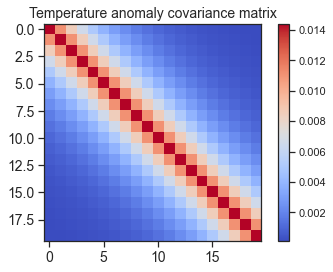

In [21]:
plt.imshow(spatial_temp, cmap='coolwarm')#, vmin=0., vmax=1.)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.colorbar()
plt.title("Temperature anomaly covariance matrix", fontsize=14)

## Function that modifies a connectivity matrix to "bias" the diagonal: bias_diagonal()

In [22]:
def bias_diagonal(A, alpha):
    I = np.identity(A.shape[0])
    A_bias = (1-alpha)*A + alpha*I
    return A_bias

## Function that generates a normalized random matrix such that all columns (i.e. source sites) sum to 1: D_random()

In [23]:
def D_random(size):
    D0 = np.random.rand(size,size)
    D_rand  = np.zeros((size,size)) # Preallocate matrix
    for i in np.arange(size):
        D_rand[:,i]  = D0[:,i] / D0[:,i].sum()
    return D_rand

## Function that generates a matrix that approximates a linear configuration such that each patch can only send larvae to its two adjacent patches: D_linear()

In [24]:
def D_linear(size, p_dispersal):
    D_linear = np.zeros((size,size))
    
    for i in np.arange(0,size):
        D_linear[i,i]= 1-p_dispersal*2
        if i != 0 and i != size-1:
            D_linear[i,i-1] = p_dispersal
            D_linear[i,i+1] = p_dispersal
        if i != 0 and i == size-1:
            D_linear[i,i-1] = p_dispersal
        if i == 0 and i != size-1:
            D_linear[i,i+1] = p_dispersal
            
    return D_linear  

# MAIN ROUTINE

Run eco-evo simulations and generate output

In [25]:
np.random.seed(0)

In [26]:
#! Load connectivity matrices
D_reg = np.load("D_reg.npy")
D_rand = np.load("D_rand.npy")

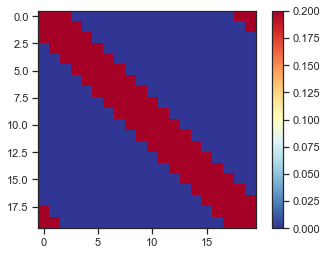

In [27]:
plt.imshow(D_reg, cmap='RdYlBu_r')
plt.colorbar()

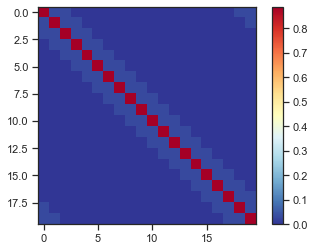

In [28]:
D_bias = bias_diagonal(D_reg,0.86)
plt.imshow(D_bias, cmap="RdYlBu_r")
plt.colorbar()

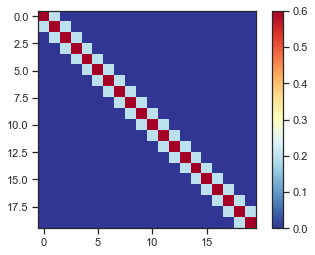

In [29]:
plt.imshow(D_linear(20, 0.2), cmap='RdYlBu_r')
plt.colorbar()

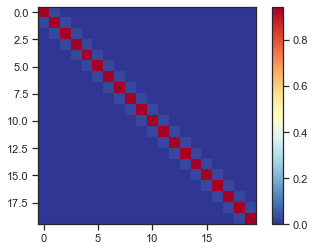

In [30]:
D_bias = bias_diagonal(D_linear(20, 0.2),0.86)
plt.imshow(D_bias, cmap="RdYlBu_r")
plt.colorbar()

In [31]:
anomalies_burn = (np.tile(np.random.normal(0,temp_stoch,burnin),size).reshape((size,burnin)) 
                  + np.random.multivariate_normal(np.repeat(0,size),spatial_temp,burnin).T)

anomalies_run = (np.tile(np.random.normal(0,temp_stoch,runtime),size).reshape((size,runtime)) 
                + np.random.multivariate_normal(np.repeat(0,size),spatial_temp,runtime).T)

algaemort = np.random.uniform(0.1,0.1,(runtime+burnin)*size).reshape((size,runtime+burnin))

SST0 = generate_temps_fun(size,mid,temp_range,temp_scenario='random')
spp_state = generate_state_fun(size, nsp, cover=0.25,random=False)
trait_state = generate_traits_fun(nsp,size,SST0,mid,temp_range,trait_scenario='perfect_adapt')
mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')

## Cosine temperature

In [32]:
anomalies_burn = np.tile(np.random.normal(0,temp_stoch,burnin),size).reshape((size,burnin)) 

anomalies_run = np.tile(np.random.normal(0,temp_stoch,runtime),size).reshape((size,runtime)) 

algaemort = np.random.uniform(0.1,0.1,(runtime+burnin)*size).reshape((size,runtime+burnin))

SST0 = generate_temps_cos_fun(size,min_SST=20,max_SST=30)
spp_state = generate_state_fun(size, nsp, cover=0.25,random=False)
trait_state = generate_traits_fun(nsp,size,SST0,mid,temp_range,trait_scenario='perfect_adapt')
mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')

Define variable "D" to choose network type in cell below. 

In [33]:
# Choose the type of connectivity matrix: 

#D = D_reg #FOR REGULAR NETWORK
D = D_linear(size,0.4) #FOR LINEAR NETWORK

In [39]:
#burnin parameters
time_steps=burnin
timemod = 0 #to offset algae mortality index
parameters_dict = {'nsp': nsp, 
                    'size': size, 
                    'time_steps': burnin, 
                    'species_type': species_type, 
                    'V': V, 
                    'D': D, 
                    'beta': beta,
                    'r_max': r_max,
                    'alphas': alphas,
                    'mortality_model': mortality_model,
                    'mpa_status': mpa_status,
                    'w': w,
                    'm_const': m_const,
                    'maxtemp': maxtemp,
                    'annual_temp_change': annual_temp_change,
                    'timemod':timemod
                    }

In [40]:
#runtime parameters
mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.5,strategy='none')
time_steps = runtime
timemod = burnin #to offset algae mortality index
parameters_dict = {'nsp': nsp, 
                    'size': size, 
                    'time_steps': runtime, 
                    'species_type': species_type, 
                    'V': V, 
                    'D': D, 
                    'beta': beta,
                    'r_max': r_max,
                    'alphas': alphas,
                    'mortality_model': mortality_model,
                    'mpa_status': mpa_status,
                    'w': w,
                    'm_const': m_const,
                    'maxtemp': maxtemp,
                    'annual_temp_change': annual_temp_change,
                    'timemod':timemod
                    }

In [34]:
color_idx = np.linspace(0, 1, 10)
cmap = discrete_cmap(10, base_cmap="RdYlBu")

# Run simulations across different regions

Input path name for simulation output files in cell below

In [49]:
# Input path of data
filename = r"" #paste path here
slice_name = filename.split('/')[:-2] #edit forward slash for windows os
path = ('/').join(slice_name)

path

''

In [35]:
df = pd.read_csv("regional_temp.csv")
df

,region,name,temp_range,init_mean_rcp85,min_mean_rcp85,max_mean_rcp85,avg_mean_rcp85,var_mean_rcp85,roc_mean_rcp85,init_mean_rcp45,...,roc_anom_rcp45,init_anom_rcp26,min_anom_rcp26,max_anom_rcp26,avg_anom_rcp26,var_anom_rcp26,roc_anom_rcp26,range_anom_rcp85,range_anom_rcp45,range_anom_rcp26
0,1,East bering sea,1.230199,4.911751,4.774715,9.029284,6.764730,1.731253,0.050002,4.824088,...,0.023329,0.955977,0.360492,1.988443,1.342175,0.137559,0.010124,4.254569,2.045594,1.627951
1,2,gulf of alaska,2.382953,10.257032,10.131454,13.817023,11.846995,1.194193,0.041574,10.353555,...,0.019473,0.501543,0.387695,1.830257,1.269070,0.127153,0.010328,3.685569,1.651536,1.442562
2,3,california current,4.628319,17.605526,17.605526,20.906023,19.143753,0.916910,0.036495,17.685484,...,0.017340,0.440742,0.207148,1.533293,1.112776,0.072234,0.007893,3.300497,1.447712,1.326145
3,4,gulf of california,2.622873,26.404886,26.404886,29.475803,27.828953,0.851651,0.035199,26.401470,...,0.015651,0.274614,0.192671,1.087255,0.775649,0.044815,0.005788,3.070917,1.388180,0.894585
4,5,gulf of mexico,1.223297,25.860142,25.860142,28.951586,27.285759,0.847323,0.035139,25.805954,...,0.015384,0.276224,0.242937,1.133507,0.839168,0.040748,0.005314,3.091444,1.456837,0.890570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,62,black sea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
62,63,hudson bay complex,NaN,1.286226,1.146098,4.925440,2.693993,1.239378,0.042058,1.102491,...,NaN,0.193254,0.142942,1.401672,0.912162,0.086191,0.007512,0.000000,0.000000,1.258730
63,64,central arctic ocean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.023507,0.005435,0.346077,0.158069,0.005797,0.002445,0.000000,0.000000,0.340642
64,65,aleutian islands,0.280280,6.327539,6.247079,10.017366,7.981888,1.359302,0.044322,6.293558,...,0.021136,0.619959,0.296402,1.823789,1.255669,0.103843,0.010134,3.770287,1.865285,1.527387


## Constant temperature simulations
RCP scenario can be changed by altering parameters read in from 'regional_temp.csv' where specific RCP is specified (e.g., changing between "init_mean_rcp26," "init_mean_rcp45," "init_mean_rcp85"). Please also note that there are two definitions for "SST0" depending on which network type is chosen.

In [94]:
#Set parameters:
nsp = 1 # Number of species in model
size = 20 # Number of reefs in model, size is 60 in Walsworth et al. model
burnin = 1000 # Length of burn-in period
runtime = 90 # Length of environmental change period
species_type = np.array([[1]]) # Species type ID
species = ["C1"] # Species labels
iterations = 50 # Number of stochastic iterations
r_max = np.array([[1.]])
beta = np.array([[0.05]])
#species have no effect on each other or themselves
alphas = np.array([[1.]]) 
m_const = 0.1 # Value used for constant mortality case
mortality_model = "temp_vary"

anomalies_burn = np.tile(np.random.normal(0,temp_stoch,burnin),size).reshape((size,burnin)) 
anomalies_run = np.tile(np.random.normal(0,temp_stoch,runtime),size).reshape((size,runtime)) 
algaemort = np.random.uniform(0.1,0.1,(runtime+burnin)*size).reshape((size,runtime+burnin))
mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')


#Simulation parameters
length = 5
w_array = np.linspace(0.5,1,length)
V_array = np.linspace(0.01,0.1,length)

test_regions = [50, 60]

# for i in np.arange(1,67): #iterates over all regions 
for i in test_regions: 
    temp_range = df['temp_range'][df['region']==i].values[0]
    init = df['init_mean_rcp45'][df['region']==i].values[0] 
    maxtemp = df['max_mean_rcp45'][df['region']==i].values[0] 
    annual_temp_change = df['roc_anom_rcp45'][df['region']==i].values[0] 
    temp_stoch = df['var_anom_rcp45'][df['region']==i].values[0] 
    
#     SST0 = generate_temps_cos_fun(size, min_SST=init-temp_range, max_SST=init+temp_range) #FOR REGULAR NETWORK
    SST0 = generate_temps_linear(size, min_SST=init-temp_range, max_SST=init+temp_range) #FOR LINEAR NETWORK
    spp_state = generate_state_fun(size, nsp, cover=0.25,random=False)
    trait_state = generate_traits_fun(nsp,size,SST0,mid,temp_range,trait_scenario='perfect_adapt')
    
    for w in w_array:
        w = np.array([[w]])
        for V in V_array:
            V = np.array([[V]])
            
            #burnin parameters
            time_steps=burnin
            timemod = 0 #to offset algae mortality index
            parameters_dict = {'nsp': nsp, 
                                'size': size, 
                                'time_steps': burnin, 
                                'species_type': species_type, 
                                'V': V, 
                                'D': D, 
                                'beta': beta,
                                'r_max': r_max,
                                'alphas': alphas,
                                'mortality_model': mortality_model,
                                'mpa_status': mpa_status,
                                'w': w,
                                'm_const': m_const,
                                'maxtemp': maxtemp,
                                'annual_temp_change': annual_temp_change,
                                'timemod':timemod
                                }
            
            
            N0, Z0, SST = coral_trait_stoch_fun0(parameters_dict,spp_state,trait_state,SST0,anomalies_burn,algaemort,temp_change="constant")
            np.save(path+"/linear/N0_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", N0)
            np.save(path+"/linear/Z0_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", Z0)
            np.save(path+"/linear/SST_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", SST)

## Temperature change simulations

In [96]:
#Set parameters:
nsp = 1 # Number of species in model
size = 20 # Number of reefs in model, size is 60 in Walsworth et al. model
burnin = 1000 # Length of burn-in period
runtime = 90 # Length of environmental change period
species_type = np.array([[1]]) # Species type ID
species = ["C1"] # Species labels
iterations = 50 # Number of stochastic iterations
r_max = np.array([[1.]])
beta = np.array([[0.05]])
#species have no effect on each other or themselves
alphas = np.array([[1.]]) 
m_const = 0.1 # Value used for constant mortality case
mortality_model = "temp_vary"

# test_regions = [53, 50, 60, 13]
test_regions = [50, 60]

#Simulation parameters
length = 5
w_array = np.linspace(0.5,1,length)
V_array = np.linspace(0.01,0.1,length)

# for i in np.arange(1,67): #iterates over all regions
for i in test_regions: 
    temp_range = df['temp_range'][df['region']==i].values[0]
    init = df['init_mean_rcp45'][df['region']==i].values[0]
    maxtemp = df['max_mean_rcp45'][df['region']==i].values[0] 
    annual_temp_change = df['roc_anom_rcp45'][df['region']==i].values[0] 
    temp_stoch = df['var_anom_rcp45'][df['region']==i].values[0] 
    
#     SST0 = generate_temps_cos_fun(size, min_SST=init-temp_range, max_SST=init+temp_range)
    SST0 = generate_temps_linear(size, min_SST=init-temp_range, max_SST=init+temp_range)
    spp_state = generate_state_fun(size, nsp, cover=0.25,random=False)
    trait_state = generate_traits_fun(nsp,size,SST0,mid,temp_range,trait_scenario='perfect_adapt')
    mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')
    
    anomalies_burn = np.tile(np.random.normal(0,temp_stoch,burnin),size).reshape((size,burnin)) 
    anomalies_run = np.tile(np.random.normal(0,temp_stoch,runtime),size).reshape((size,runtime)) 
    algaemort = np.random.uniform(0.1,0.1,(runtime+burnin)*size).reshape((size,runtime+burnin))
    
    for w in w_array:
        w = np.array([[w]])
        for V in V_array:
            V = np.array([[V]])
            
            N0 = np.load(path+"/linear/N0_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy")
            SST0 = np.load(path+"/linear/SST_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy")
            Z0 = np.load(path+"/linear/Z0_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy")

            #runtime parameters
            time_steps=runtime
            timemod = burnin #to offset algae mortality index
            parameters_dict = {'nsp': nsp, 
                                'size': size, 
                                'time_steps': runtime, 
                                'species_type': species_type, 
                                'V': V, 
                                'D': D, 
                                'beta': beta,
                                'r_max': r_max,
                                'alphas': alphas,
                                'mortality_model': mortality_model,
                                'mpa_status': mpa_status,
                                'w': w,
                                'm_const': m_const,
                                'maxtemp': maxtemp,
                                'annual_temp_change': annual_temp_change,
                                'timemod':timemod
                                }
            
            
            N1, Z1, SST1 = coral_trait_stoch_fun0(parameters_dict,N0[:,:,-1],Z0[:,:,-1],SST0[:,-1],anomalies_burn,algaemort,temp_change="sigmoid")
            np.save(path+"/linear/N1_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", N1)
            np.save(path+"/linear/Z1_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", Z1)
            np.save(path+"/linear/SST1_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", SST1)

# Testing mortality

In [41]:
#Set parameters:
nsp = 1 # Number of species in model
size = 20 # Number of reefs in model, size is 60 in Walsworth et al. model
burnin = 1000 # Length of burn-in period
runtime = 90 # Length of environmental change period
species_type = np.array([[1]]) # Species type ID
species = ["C1"] # Species labels
iterations = 50 # Number of stochastic iterations
r_max = np.array([[1.]])
beta = np.array([[0.05]])
#species have no effect on each other or themselves
alphas = np.array([[1.]]) 
m_const = 0.1 # Value used for constant mortality case
mortality_model = "temp_vary"


#Simulation parameters
length = 5
w_array = np.linspace(0.5,1,length)
V_array = np.linspace(0.01,0.1,length)

test_regions = [53, 50, 60, 13]

for i in test_regions: #iterates over all regions
    temp_range = df['temp_range'][df['region']==i].values[0]
    init = df['init_mean_rcp45'][df['region']==i].values[0]
    maxtemp = df['max_mean_rcp45'][df['region']==i].values[0] 
    annual_temp_change = df['roc_anom_rcp45'][df['region']==i].values[0] 
    temp_stoch = df['var_anom_rcp45'][df['region']==i].values[0] 
    
    SST0 = generate_temps_cos_fun(size, min_SST=init-temp_range, max_SST=init+temp_range) 
    spp_state = generate_state_fun(size, nsp, cover=0.25,random=False)
    trait_state = generate_traits_fun(nsp,size,SST0,mid,temp_range,trait_scenario='perfect_adapt')
    mpa_status = set_MPA_fun(SST0,spp_state,species_type,size,amount=0.2,strategy='none')
    
    anomalies_burn = np.tile(np.random.normal(0,temp_stoch,burnin),size).reshape((size,burnin)) 
    anomalies_run = np.tile(np.random.normal(0,temp_stoch,runtime),size).reshape((size,runtime)) 
    algaemort = np.random.uniform(0.1,0.1,(runtime+burnin)*size).reshape((size,runtime+burnin))
    
    for w in w_array:
        w = np.array([[w]])
        for V in V_array:
            V = np.array([[V]])
            

            N0 = np.load(path+"/constant_45/N0_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy")
            SST0 = np.load(path+"/constant_45/SST_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy")
            Z0 = np.load(path+"/constant_45/Z0_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy")

            #runtime parameters
            time_steps=runtime
            timemod = burnin #to offset algae mortality index
            parameters_dict = {'nsp': nsp, 
                                'size': size, 
                                'time_steps': runtime, 
                                'species_type': species_type, 
                                'V': V, 
                                'D': D, 
                                'beta': beta,
                                'r_max': r_max,
                                'alphas': alphas,
                                'mortality_model': mortality_model,
                                'mpa_status': mpa_status,
                                'w': w,
                                'm_const': m_const,
                                'maxtemp': maxtemp,
                                'annual_temp_change': annual_temp_change,
                                'timemod':timemod
                                }
            
            
            N1, Z1, SST1 = coral_trait_stoch_fun0(parameters_dict,N0[:,:,-1],Z0[:,:,-1],SST0[:,-1],anomalies_burn,algaemort,temp_change="sigmoid")
            np.save(path+"/N1_mort_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", N1)
            np.save(path+"/Z1_mort_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", Z1)
            np.save(path+"/SST1_mort_region_"+str(i)+"_w"+str(w[0])+"_V"+str(V[0])+".npy", SST1)

# Supplemental figures

# Supplement Figure S7 <a class="anchor" id="Network"></a>

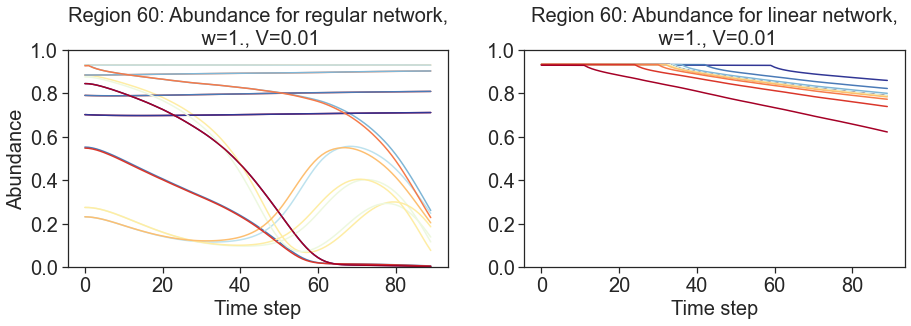

In [43]:
# TEST LINEAR NETWORK VS REGULAR NETWORK HERE
region = '60'
w = "1."
v = "0.01"

N0 = np.load(path+"/change_rcp45/N1_region_"+region+"_w["+w+"]_V["+v+"].npy")
N1 = np.load(path+"/linear/N1_region_"+region+"_w["+w+"]_V["+v+"].npy")
Z0 = np.load(path+"/change_rcp45/Z1_region_"+region+"_w["+w+"]_V["+v+"].npy")
Z1 = np.load(path+"/linear/Z1_region_"+region+"_w["+w+"]_V["+v+"].npy")
SST0 = np.load(path+"/change_rcp45/SST1_region_"+region+"_w["+w+"]_V["+v+"].npy")
SST1 = np.load(path+"/linear/SST1_region_"+region+"_w["+w+"]_V["+v+"].npy")

f, ax =  plt.subplots(1,2, figsize=(15,4))

coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[0].plot(N0[i,coral, :], color=cmap(idx))
    ax[0].set_xlabel("Time step", size=20)
    ax[0].set_ylabel("Abundance", size=20)

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[0].plot(N0[i,coral,:], color=cmap(idx))
    ax[0].set_title("Region "+str(region)+": Abundance for regular network,\n w=1., V=0.01", size=20)
    ax[0].tick_params(axis='both', which='major',labelsize=20)
    ax[0].set_ylim(0, 1.0)
    
coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[1].plot(N1[i,coral,:], color=cmap(idx))
    ax[1].set_xlabel("Time step", size=20)

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[1].plot(N1[i,coral,:], color=cmap(idx))
    ax[1].set_title("Region "+str(region)+": Abundance for linear network,\n w=1., V=0.01", size=20)
    ax[1].tick_params(axis='both', which='major',labelsize=20)
    ax[1].set_ylim(0, 1.0)

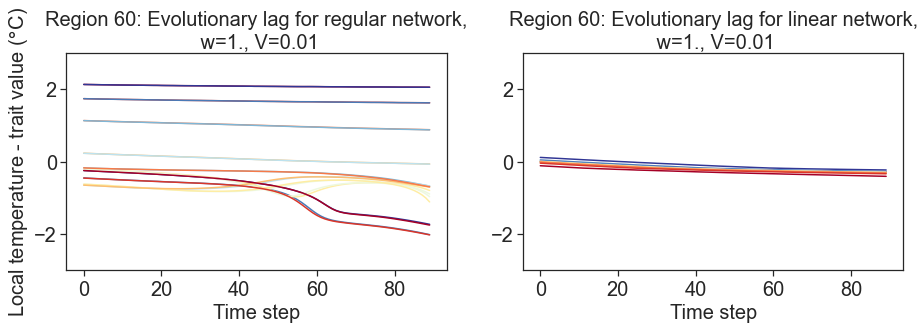

In [46]:
f, ax =  plt.subplots(1,2, figsize=(15,4))

coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[0].plot(Z0[i,coral,:]-SST0[i,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[0].plot(Z0[i,coral,:]-SST0[i,:], color=cmap(idx))
    ax[0].set_title("Region "+str(region)+": Evolutionary lag for regular network,\n w="+w+", V="+v+"", size=20)
    ax[0].set_xlabel("Time step", size=20)
    ax[0].set_ylabel("Local temperature - trait value ($\degree$C)", size=20)
    ax[0].tick_params(axis='both', which='major',labelsize=20)
    ax[0].set_ylim(-3,3)
    
coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[1].plot(Z1[i,coral,:]-SST1[i,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[1].plot(Z1[i,coral,:]-SST1[i,:], color=cmap(idx))
    ax[1].set_title("Region "+str(region)+": Evolutionary lag for linear network,\n w="+w+", V="+v+"", size=20)
    ax[1].set_xlabel("Time step", size=20)
    ax[1].tick_params(axis='both', which='major',labelsize=20)
    ax[1].set_ylim(-3,3)
    

# Supplement Figure S8 <a class="anchor" id="Mortality"></a>

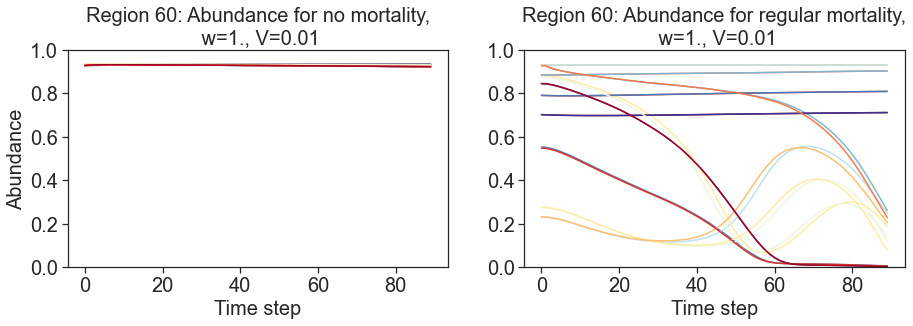

In [48]:
# TEST MORTALITY FUNCTION HERE
region = "60"
w = "1."
v = "0.01"

N0 = np.load(path+"/mort_fun/N1_mort_region_"+region+"_w["+w+"]_V["+v+"].npy")
N1 = np.load(path+"/change_rcp45/N1_region_"+region+"_w["+w+"]_V["+v+"].npy")
Z0 = np.load(path+"/mort_fun/Z1_mort_region_"+region+"_w["+w+"]_V["+v+"].npy")
Z1 = np.load(path+"/change_rcp45/Z1_region_"+region+"_w["+w+"]_V["+v+"].npy")
SST0 = np.load(path+"/mort_fun/SST1_mort_region_"+region+"_w["+w+"]_V["+v+"].npy")
SST1 = np.load(path+"/change_rcp45/SST1_region_"+region+"_w["+w+"]_V["+v+"].npy")

f, ax =  plt.subplots(1,2, figsize=(15,4))

coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[0].plot(N0[i,coral,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[0].plot(N0[i,coral,:], color=cmap(idx))
    ax[0].set_title("Region "+str(region)+": Abundance for no mortality,\n w="+w+", V="+v+"", size=20)
    ax[0].set_xlabel("Time step", size=20)
    ax[0].set_ylabel("Abundance", size=20)
    ax[0].tick_params(axis='both', which='major',labelsize=20)
    ax[0].set_ylim(0, 1)
    
coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[1].plot(N1[i,coral,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[1].plot(N1[i,coral,:], color=cmap(idx))
    ax[1].set_title("Region "+str(region)+": Abundance for regular mortality,\n w="+w+", V="+v+"", size=20)
    ax[1].set_xlabel("Time step", size=20)
    ax[1].tick_params(axis='both', which='major',labelsize=20)
    ax[1].set_ylim(0, 1)

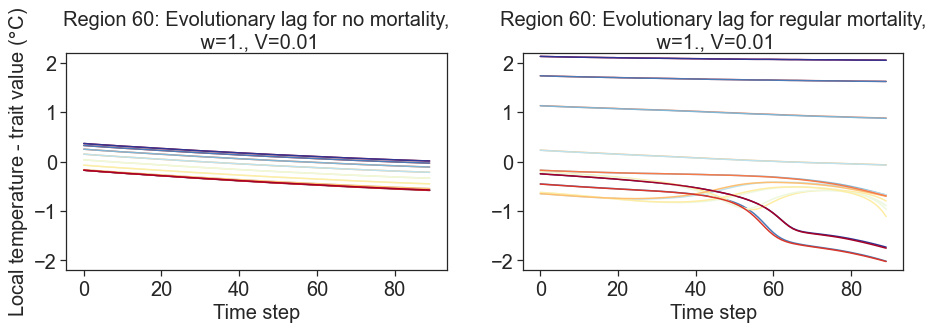

In [84]:
f, ax =  plt.subplots(1,2, figsize=(15,4))

coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[0].plot(Z0[i,coral,:]-SST0[i,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[0].plot(Z0[i,coral,:]-SST0[i,:], color=cmap(idx))
    ax[0].set_title("Region "+str(region)+": Evolutionary lag for no mortality,\n w="+w+", V="+v+"", size=20)
    ax[0].set_xlabel("Time step", size=20)
    ax[0].set_ylabel("Local temperature - trait value ($\degree$C)", size=20)
    ax[0].tick_params(axis='both', which='major',labelsize=20)
    ax[0].set_ylim(-2.2, 2.2)
    
coral = 0
for i, idx in zip(np.arange(0,10), color_idx):
    ax[1].plot(Z1[i,coral,:]-SST1[i,:], color=cmap(idx))

cmap = discrete_cmap(10, base_cmap="RdYlBu_r")
for i, idx in zip(np.arange(10,20), color_idx):
    ax[1].plot(Z1[i,coral,:]-SST1[i,:], color=cmap(idx))
    ax[1].set_title("Region "+str(region)+": Evolutionary lag for regular mortality,\n w="+w+", V="+v+"", size=20)
    ax[1].set_xlabel("Time step", size=20)
    ax[1].tick_params(axis='both', which='major',labelsize=20)
    ax[1].set_ylim(-2.2, 2.2)